# Comparative Analysis of Self-Supervised and Supervised Pretraining Approaches for Genshin Impact Character Classification Using ResNet-18

This notebook implements an experimental framework to compare self-supervised and supervised pretraining approaches for the task of Genshin Impact character classification using the ResNet-18 architecture. The goal is to evaluate the effectiveness of different pretraining strategies in leveraging limited labeled data for improved classification performance.

## Required Libraries
- PyTorch
- Torchvision
- NumPy
- Matplotlib
- Pandas
- Scikit-learn
- Seaborn
- Hugging Face (Optional for model uploading)
- Kaggle (for dataset management)

## Key elements of the implementation:
- **Image Preprocessing**:
    - Image resizing to 256x256 pixels with stretching and no aspect ratio preservation.
    - Normalization using ImageNet statistics.

- **Data Augmentation**:
    - Random cropping, horizontal flipping, color jittering, and Gaussian blur for SimCLR pretraining.
    - Random scaling $[1.0, 1.5]$ with random center cropping, rotation $[-15^\circ, 15^\circ]$ and horizontal flipping for fine-tuning.

- **Model Architecture**:
    - ResNet-18 with a projection head for SimCLR pretraining.
    - Classification MLP head for fine-tuning with 6 output classes.

- **Training Configuration**:
    - SimCLR pretraining with 500 epochs, batch size of 256, and a learning rate of 0.5.
    - Fine-tuning with 100 epochs, batch size of 32, and a learning rate of 0.01, with gradual unfreezing ResNet layers.

- **Loss Functions**:
    - Contrastive loss with temperature scaling for SimCLR pretraining.
    - Cross-entropy loss for classification fine-tuning.

> The contrastive loss is computed using the cosine similarity between the projected features of positive pairs, while the classification loss is computed using the softmax output of the final classification layer.


- **Evaluation Metrics**:
    - Cross-validation with 5 folds to ensure robustness.
    - Top-1 and Top-5 accuracy, F1-score, precision, recall, and confusion matrix analysis.
    - Visualization of learned features using t-SNE and Grad-CAM for interpretability.

- **Models Training Approaches**:
    - Pure supervised training on final dataset. (Comparison baseline)
    - Self-supervised pretraining on unlabeled dataset followed by fine-tuning by supervised training on the final dataset.
    - Self-supervised pretraining on unlabeled dataset followed by fine-tuning by semi-supervised training on the final dataset + non labeled dataset.
    - ImageNet supervised pretraining followed by fine-tuning by supervised training on the final dataset.

## 1. Dependencies import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from tqdm import tqdm
from PIL import Image

## 2.Check if GPU is available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / (1024 ** 3):.2f} GB")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / (1024 ** 3):.2f} GB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0) / (1024 ** 3):.2f} GB")

Using device: cuda
NVIDIA GeForce RTX 3050 Laptop GPU
Memory Available: 4.00 GB
Memory Allocated: 0.00 GB
Memory Cached: 0.00 GB


In [3]:
torch.backends.cudnn.allow_tf32 = False
torch.backends.cuda.matmul.allow_tf32 = False

# Set default tensor type to float32
#torch.set_default_dtype(torch.float32)

print(f"TF32 for cuDNN: {torch.backends.cudnn.allow_tf32}")
print(f"TF32 for matmul: {torch.backends.cuda.matmul.allow_tf32}")
print(f"Default tensor dtype: {torch.get_default_dtype()}")

TF32 for cuDNN: False
TF32 for matmul: False
Default tensor dtype: torch.float32


In [4]:
!nvidia-smi

Sun Jul 20 14:53:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   73C    P0             16W /   60W |     249MiB /   4096MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 3. Dataset retrieval and transformation for Self-Supervised Learning dataset
- Download the Genshin Impact character dataset from Kaggle.
- Apply image transformations.
- Save as a single dataset for self-supervised learning.

Combined dataset already exists. Loading...


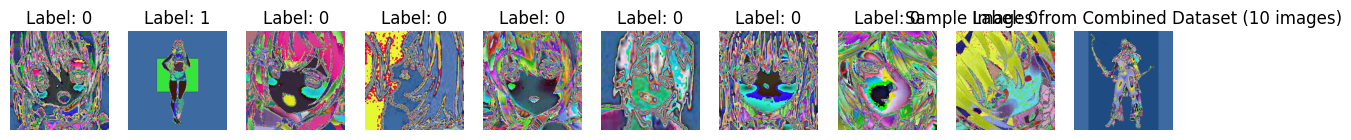

In [5]:
IMAGENET_MEAN = [0.485, 0.456, 0.406] #Using ImageNet mean and std for normalization
IMAGENET_STD = [0.229, 0.224, 0.225]
N = 10

if os.path.exists(os.path.join(os.getcwd(), "datasets", "ssl-dataset.pt")): # check if the combined dataset exists
    print("Combined dataset already exists. Loading...")
    combined_dataset = torch.load(os.path.join(os.getcwd(), "datasets", "ssl-dataset.pt"), weights_only=False)
else: #if not, download, process the datasets and save the combined dataset
    print("Combined dataset does not exist. Downloading and processing datasets...")

    ds1_path = kagglehub.dataset_download("soumikrakshit/anime-faces")
    ds2_path = kagglehub.dataset_download("stevenevan99/face-of-pixiv-top-daily-illustration-2020")
    ds3_path = kagglehub.dataset_download("hirunkulphimsiri/fullbody-anime-girls-datasets")

    # Define the transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)), #256x256px resize
        transforms.ToTensor(), #convert to tensor
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) #normalize with ImageNet stats
    ])

    # Load the datasets
    dataset1 = datasets.ImageFolder(root=ds1_path, transform=transform)
    dataset2 = datasets.ImageFolder(root=ds2_path, transform=transform)
    dataset3 = datasets.ImageFolder(root=ds3_path, transform=transform)
    # Combine the datasets
    combined_dataset = torch.utils.data.ConcatDataset([dataset1, dataset2, dataset3])
    # Save the combined dataset
    combined_dataset_path = os.path.join(os.getcwd(), "datasets")
    if not os.path.exists(combined_dataset_path):
        os.makedirs(combined_dataset_path)
    torch.save(combined_dataset, os.path.join(combined_dataset_path, "ssl-dataset.pt"))

# Visualize n random images from the combined dataset
def visualize_dataset(dataset, num_images=5):
    indices = np.random.choice(len(dataset), num_images, replace=False)
    images = [dataset[i][0] for i in indices]
    labels = [dataset[i][1] for i in indices]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(F.to_pil_image(img))
        ax.axis('off')
        ax.set_title(f"Label: {label}")
    plt.title(f"Sample Images from Combined Dataset ({num_images} images)")
    plt.show()
visualize_dataset(combined_dataset, num_images=N)

## 4. Dataset retrieval and transformation for Supervised fine-tuning

In [6]:
try:
    from google.colab import drive # Mount Google Drive to access dataset
    drive.mount('/content/gdrive/', force_remount=True)
    dataset_path_compressed = "/content/gdrive/MyDrive/GenshinImageClassifier/dataset.zip"
except ImportError:
    dataset_path_compressed = os.path.join(os.getcwd(), "dataset.zip")

Processed dataset already exists. Loading...


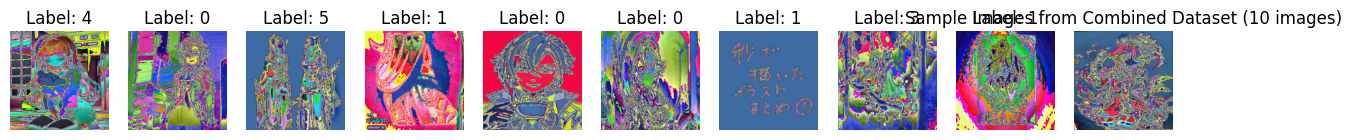

In [7]:
import zipfile
import shutil

N = 10 # Number of images to visualize

#check if the processed dataset exists
if os.path.exists(os.path.join(os.getcwd(), "datasets", "finetune-dataset.pt")):
    print("Processed dataset already exists. Loading...")
    dataset = torch.load(os.path.join(os.getcwd(), "datasets", "finetune-dataset.pt"), weights_only=False)
else:
    #check if non procceessed dataset exists
    if not os.path.exists(dataset_path_compressed):
        print(f"Dataset file at {dataset_path_compressed} does not exist. Please download it or update the path.")

    # Copy it to the current working directory in /tmp/ folder if it does not exist, create it
    if not os.path.exists(os.getcwd() + "/tmp/"):
        os.makedirs(os.getcwd() + "/tmp/")

    print(f"Copying dataset file to /tmp/ directory...")
    shutil.copy(dataset_path_compressed, os.getcwd() + "/tmp/dataset.zip")

    # Unzip the dataset
    with zipfile.ZipFile(os.getcwd() + "/tmp/dataset.zip", 'r') as zip_ref:
        zip_ref.extractall(os.getcwd() + "/tmp/")

    # Load the dataset
    dataset_path = os.path.join(os.getcwd(), "tmp", "dataset")
    if not os.path.exists(dataset_path):
        print(f"Dataset path {dataset_path} does not exist. Please check the extraction.")

    # Load the dataset using ImageFolder
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

    # Save as .pt file
    torch.save(dataset, os.path.join(os.getcwd(), "datasets", "finetune-dataset.pt"))

# Visualize n random images from the dataset
visualize_dataset(dataset, num_images=N)

## 5. Models training, evaluation and feature extraction/visualization
- Train the baseline model on the final dataset.
- Train the self-supervised model on the unlabeled dataset.
- Fine-tune the self-supervised model on the final dataset using supervised training.
- Fine-tune the self-supervised model on the final dataset using semi-supervised training.
- Fine-tune the ImageNet pre-trained model on the final dataset using supervised training.

### 5.1. Baseline Model

#### 5.1.1. Supervised Training

Starting 5-fold cross-validation on 9590 samples...
Using mixed precision training with TF32: False

FOLD 1/5
Model parameters dtype: torch.float32


/tmp/ipykernel_9987/2270530475.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_9987/2270530475.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_9987/2270530475.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/200] - Time: 543.90s
  Train - Loss: 0.5640, Acc: 81.09%
  Val   - Loss: 0.7609, Acc: 76.75%
Epoch [20/200] - Time: 474.12s
  Train - Loss: 0.2210, Acc: 92.28%
  Val   - Loss: 0.8245, Acc: 79.14%
Epoch [30/200] - Time: 477.34s
  Train - Loss: 0.1111, Acc: 95.92%
  Val   - Loss: 0.8696, Acc: 80.29%
Epoch [40/200] - Time: 482.08s
  Train - Loss: 0.0623, Acc: 96.56%
  Val   - Loss: 1.0503, Acc: 80.60%
Epoch [50/200] - Time: 482.76s
  Train - Loss: 0.0461, Acc: 96.86%
  Val   - Loss: 1.1930, Acc: 81.13%
Epoch [60/200] - Time: 480.45s
  Train - Loss: 0.0478, Acc: 96.94%
  Val   - Loss: 1.2996, Acc: 80.40%
Epoch [70/200] - Time: 480.94s
  Train - Loss: 0.0497, Acc: 96.92%
  Val   - Loss: 1.3119, Acc: 80.76%
Epoch [80/200] - Time: 482.96s
  Train - Loss: 0.1148, Acc: 95.14%
  Val   - Loss: 1.4545, Acc: 76.17%
Epoch [90/200] - Time: 552.35s
  Train - Loss: 0.0617, Acc: 96.57%
  Val   - Loss: 1.3220, Acc: 79.25%
Epoch [100/200] - Time: 537.55s
  Train - Loss: 0.0365, Acc: 97.26%
  Val

/tmp/ipykernel_9987/2270530475.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Fold 1 Results:
  Best Validation Accuracy: 82.22%
  Test Accuracy: 82.22%
  Test F1-Score: 0.8227
  Test Precision: 0.8254
  Test Recall: 0.8217

FOLD 2/5
Model parameters dtype: torch.float32


/tmp/ipykernel_9987/2270530475.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_9987/2270530475.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_9987/2270530475.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/200] - Time: 470.55s
  Train - Loss: 0.5984, Acc: 79.80%
  Val   - Loss: 0.7760, Acc: 75.86%
Epoch [20/200] - Time: 482.96s
  Train - Loss: 0.2336, Acc: 91.98%
  Val   - Loss: 1.0365, Acc: 76.80%
Epoch [30/200] - Time: 470.41s
  Train - Loss: 0.1295, Acc: 95.36%
  Val   - Loss: 0.8609, Acc: 78.99%
Epoch [40/200] - Time: 469.54s
  Train - Loss: 0.0976, Acc: 95.80%
  Val   - Loss: 1.1109, Acc: 78.78%
Epoch [50/200] - Time: 468.77s
  Train - Loss: 0.0443, Acc: 96.77%
  Val   - Loss: 1.3591, Acc: 80.14%
Epoch [60/200] - Time: 474.23s
  Train - Loss: 0.1056, Acc: 95.58%
  Val   - Loss: 1.1013, Acc: 78.78%
Epoch [70/200] - Time: 490.20s
  Train - Loss: 0.0379, Acc: 97.15%
  Val   - Loss: 1.3124, Acc: 80.55%
Epoch [80/200] - Time: 471.02s
  Train - Loss: 0.0585, Acc: 96.92%
  Val   - Loss: 1.1851, Acc: 80.19%
Epoch [90/200] - Time: 470.84s
  Train - Loss: 0.0359, Acc: 97.18%
  Val   - Loss: 1.4493, Acc: 80.50%
Epoch [100/200] - Time: 471.00s
  Train - Loss: 0.1649, Acc: 94.19%
  Val

/tmp/ipykernel_9987/2270530475.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Fold 2 Results:
  Best Validation Accuracy: 81.60%
  Test Accuracy: 81.60%
  Test F1-Score: 0.8156
  Test Precision: 0.8173
  Test Recall: 0.8147

FOLD 3/5
Model parameters dtype: torch.float32


/tmp/ipykernel_9987/2270530475.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_9987/2270530475.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_9987/2270530475.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/200] - Time: 483.33s
  Train - Loss: 0.5517, Acc: 81.63%
  Val   - Loss: 0.9734, Acc: 70.07%
Epoch [20/200] - Time: 482.17s
  Train - Loss: 0.2368, Acc: 91.71%
  Val   - Loss: 0.7444, Acc: 79.67%
Epoch [30/200] - Time: 484.05s
  Train - Loss: 0.1114, Acc: 95.87%
  Val   - Loss: 0.8591, Acc: 79.35%
Epoch [40/200] - Time: 476.20s
  Train - Loss: 0.1315, Acc: 94.51%
  Val   - Loss: 1.0959, Acc: 79.04%
Epoch [50/200] - Time: 470.86s
  Train - Loss: 0.0515, Acc: 96.72%
  Val   - Loss: 1.2186, Acc: 79.82%
Epoch [60/200] - Time: 470.41s
  Train - Loss: 0.0422, Acc: 96.86%
  Val   - Loss: 1.2149, Acc: 81.49%
Epoch [70/200] - Time: 468.61s
  Train - Loss: 0.0414, Acc: 97.18%
  Val   - Loss: 1.8959, Acc: 68.98%
Epoch [80/200] - Time: 471.02s
  Train - Loss: 0.0453, Acc: 97.02%
  Val   - Loss: 1.2054, Acc: 80.60%
Epoch [90/200] - Time: 477.29s
  Train - Loss: 0.0379, Acc: 97.15%
  Val   - Loss: 1.4549, Acc: 81.65%
Epoch [100/200] - Time: 477.57s
  Train - Loss: 0.0436, Acc: 96.87%
  Val

/tmp/ipykernel_9987/2270530475.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Fold 3 Results:
  Best Validation Accuracy: 82.27%
  Test Accuracy: 82.27%
  Test F1-Score: 0.8225
  Test Precision: 0.8234
  Test Recall: 0.8224

FOLD 4/5
Model parameters dtype: torch.float32


/tmp/ipykernel_9987/2270530475.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_9987/2270530475.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_9987/2270530475.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/200] - Time: 512.60s
  Train - Loss: 0.5428, Acc: 81.75%
  Val   - Loss: 0.9156, Acc: 70.28%
Epoch [20/200] - Time: 513.25s
  Train - Loss: 0.2056, Acc: 93.03%
  Val   - Loss: 0.7404, Acc: 77.22%
Epoch [30/200] - Time: 512.44s
  Train - Loss: 0.1155, Acc: 95.71%
  Val   - Loss: 0.8658, Acc: 77.89%
Epoch [40/200] - Time: 527.62s
  Train - Loss: 0.0771, Acc: 96.35%
  Val   - Loss: 1.2392, Acc: 77.01%
Epoch [50/200] - Time: 516.05s
  Train - Loss: 0.0410, Acc: 97.00%
  Val   - Loss: 1.2412, Acc: 80.08%
Epoch [60/200] - Time: 517.57s
  Train - Loss: 0.0593, Acc: 96.90%
  Val   - Loss: 1.1009, Acc: 78.78%
Epoch [70/200] - Time: 516.46s
  Train - Loss: 0.0377, Acc: 97.37%
  Val   - Loss: 1.3688, Acc: 79.25%
Epoch [80/200] - Time: 516.70s
  Train - Loss: 0.1018, Acc: 95.78%
  Val   - Loss: 9.0592, Acc: 41.03%
Epoch [90/200] - Time: 517.30s
  Train - Loss: 0.0356, Acc: 97.25%
  Val   - Loss: 1.3471, Acc: 80.24%
Epoch [100/200] - Time: 516.17s
  Train - Loss: 0.0376, Acc: 97.37%
  Val

/tmp/ipykernel_9987/2270530475.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Fold 4 Results:
  Best Validation Accuracy: 81.13%
  Test Accuracy: 81.13%
  Test F1-Score: 0.8125
  Test Precision: 0.8129
  Test Recall: 0.8128

FOLD 5/5
Model parameters dtype: torch.float32


/tmp/ipykernel_9987/2270530475.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_9987/2270530475.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_9987/2270530475.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/200] - Time: 518.95s
  Train - Loss: 0.5840, Acc: 80.70%
  Val   - Loss: 0.7108, Acc: 77.95%
Epoch [20/200] - Time: 520.46s
  Train - Loss: 0.2691, Acc: 90.50%
  Val   - Loss: 0.8788, Acc: 78.31%
Epoch [30/200] - Time: 521.20s
  Train - Loss: 0.1054, Acc: 96.35%
  Val   - Loss: 1.1215, Acc: 75.76%
Epoch [40/200] - Time: 519.31s
  Train - Loss: 0.0719, Acc: 96.48%
  Val   - Loss: 1.1502, Acc: 78.10%
Epoch [50/200] - Time: 522.30s
  Train - Loss: 0.0534, Acc: 96.98%
  Val   - Loss: 1.2966, Acc: 79.25%
Epoch [60/200] - Time: 522.45s
  Train - Loss: 0.0772, Acc: 96.29%
  Val   - Loss: 1.2845, Acc: 76.64%
Epoch [70/200] - Time: 521.95s
  Train - Loss: 0.0357, Acc: 97.29%
  Val   - Loss: 1.4513, Acc: 79.30%
Epoch [80/200] - Time: 522.59s
  Train - Loss: 0.3098, Acc: 89.90%
  Val   - Loss: 1.2574, Acc: 75.50%
Epoch [90/200] - Time: 523.11s
  Train - Loss: 0.0636, Acc: 96.65%
  Val   - Loss: 1.3797, Acc: 79.14%
Epoch [100/200] - Time: 522.50s
  Train - Loss: 0.0340, Acc: 97.33%
  Val

/tmp/ipykernel_9987/2270530475.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Fold 5 Results:
  Best Validation Accuracy: 80.66%
  Test Accuracy: 80.66%
  Test F1-Score: 0.8066
  Test Precision: 0.8089
  Test Recall: 0.8066

CROSS-VALIDATION RESULTS SUMMARY
Test Accuracy:  81.57% ± 0.62%
Test F1-Score:  0.8159 ± 0.0061
Test Precision: 0.8176 ± 0.0062
Test Recall:    0.8156 ± 0.0059


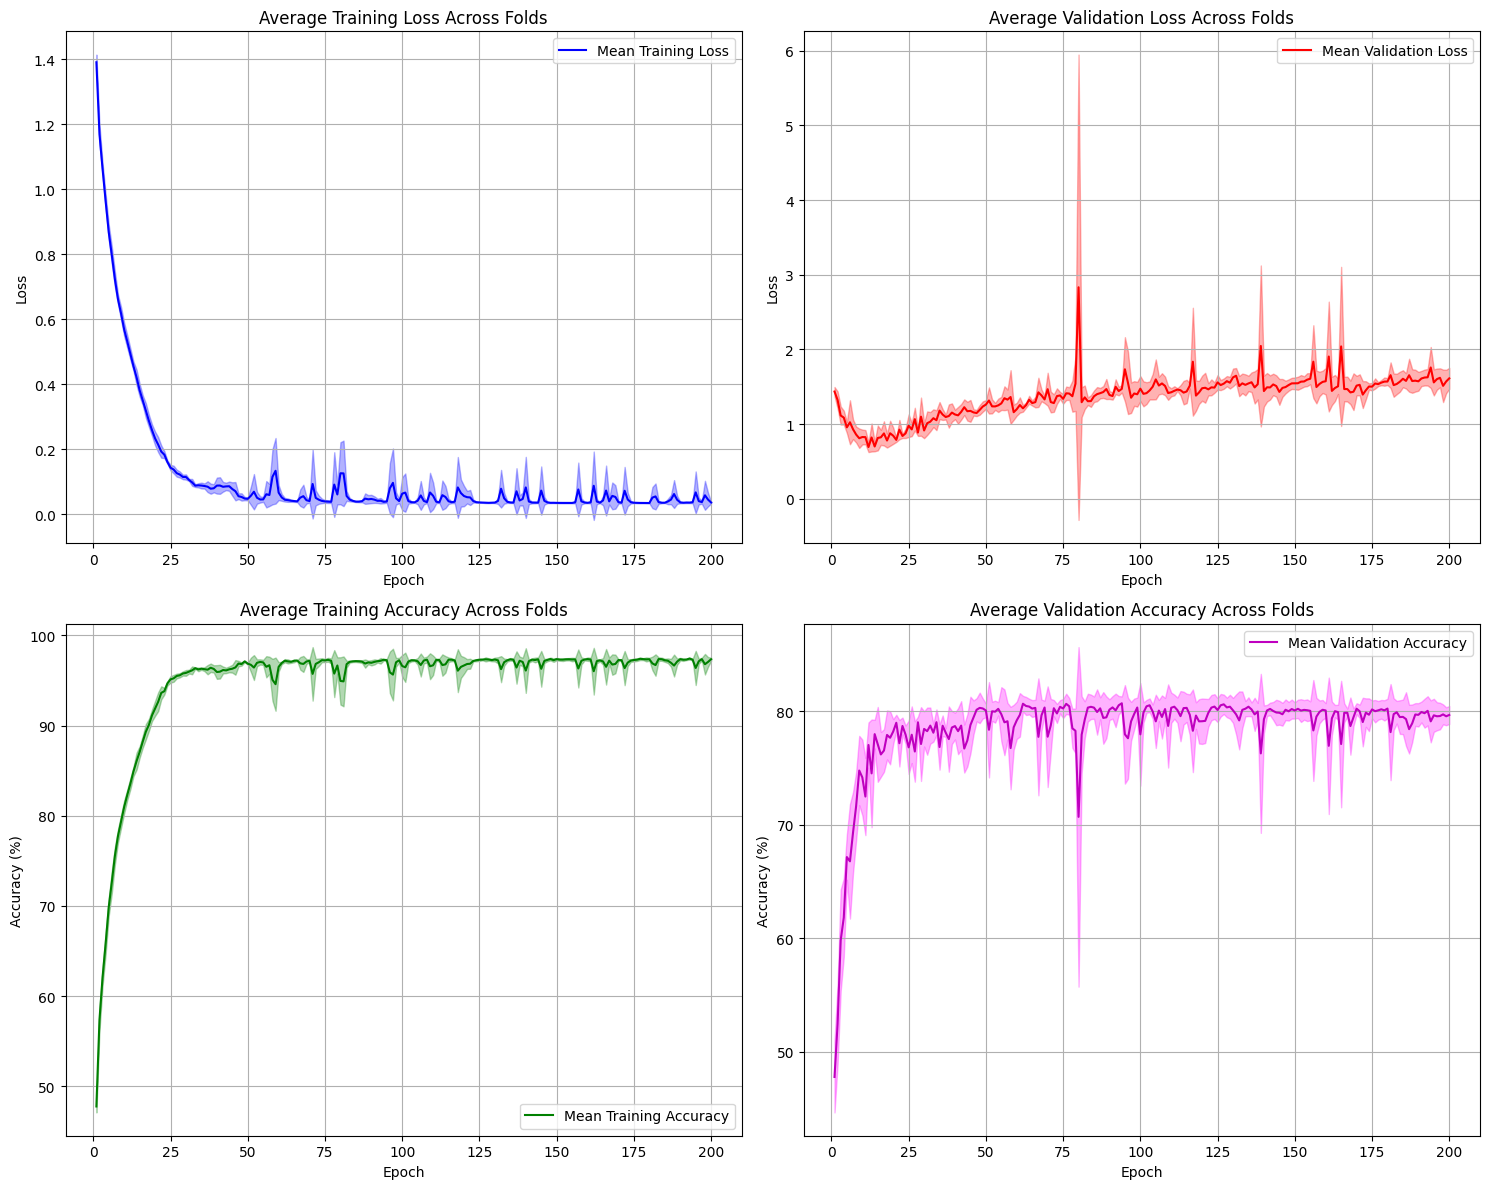

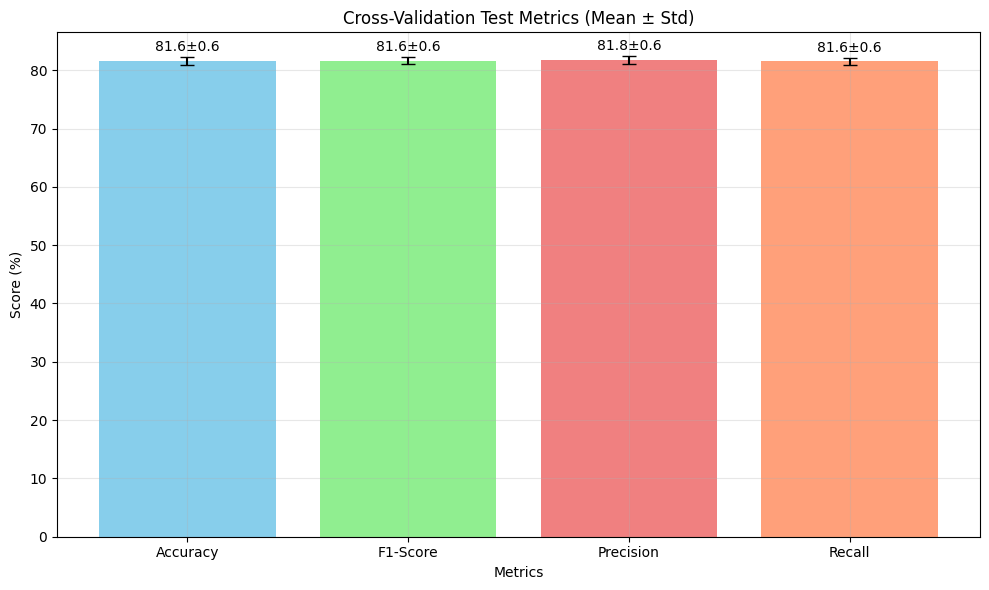

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
import copy
import time

EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001
K_FOLDS = 5

# Initialize 5-fold cross-validation
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Storage for results across folds
fold_results = {
    'train_losses': [],
    'train_accuracies': [],
    'val_losses': [],
    'val_accuracies': [],
    'test_metrics': []
}

# Get all indices for the dataset
dataset_size = len(dataset)
indices = list(range(dataset_size))

print(f"Starting {K_FOLDS}-fold cross-validation on {dataset_size} samples...")
print(f"Using mixed precision training with TF32: {torch.backends.cuda.matmul.allow_tf32}")

for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{K_FOLDS}")
    print(f"{'='*50}")

    # Create data samplers for train and validation
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=train_sampler
    )
    val_loader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=val_sampler
    )

    # Initialize model for this fold (remains in FP32)
    model = models.resnet18(weights=None, num_classes=6).to(device)
    
    # Verify model is in FP32
    print(f"Model parameters dtype: {next(model.parameters()).dtype}")

    # Define loss function and optimizer
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Initialize GradScaler for mixed precision
    scaler = GradScaler()

    # Storage for this fold's training history
    fold_train_losses = []
    fold_train_accuracies = []
    fold_val_losses = []
    fold_val_accuracies = []

    best_val_accuracy = 0.0
    best_model_state = None
    
    t_i = time.time()  # Start time

    # Training loop for this fold
    for epoch in range(EPOCHS):
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Use autocast for forward pass (enables FP16/TF32 Tensor Cores)
            with autocast():
                outputs = model(images)
                loss = loss_criterion(outputs, labels)
            
            # Scale loss and backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_idx)
        epoch_train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Use autocast for validation too
                with autocast():
                    outputs = model(images)
                    loss = loss_criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_idx)
        epoch_val_accuracy = 100 * val_correct / val_total

        # Store metrics
        fold_train_losses.append(epoch_train_loss)
        fold_train_accuracies.append(epoch_train_accuracy)
        fold_val_losses.append(epoch_val_loss)
        fold_val_accuracies.append(epoch_val_accuracy)

        # Save best model
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            best_model_state = copy.deepcopy(model.state_dict())

        # Print progress every 50 epochs
        if (epoch + 1) % 10 == 0:
            
            print(f"Epoch [{epoch+1}/{EPOCHS}] - Time: {time.time() - t_i:.2f}s")
            print(f"  Train - Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_accuracy:.2f}%")
            print(f"  Val   - Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_accuracy:.2f}%")
            t_i = time.time()

    # Load best model for final evaluation
    model.load_state_dict(best_model_state)

    # Final evaluation on validation set (as test set for this fold)
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Use autocast for final evaluation
            with autocast():
                outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate detailed metrics for this fold
    fold_accuracy = accuracy_score(all_labels, all_predictions)
    fold_f1 = f1_score(all_labels, all_predictions, average='macro')
    fold_precision = precision_score(all_labels, all_predictions, average='macro')
    fold_recall = recall_score(all_labels, all_predictions, average='macro')

    # Store fold results
    fold_results['train_losses'].append(fold_train_losses)
    fold_results['train_accuracies'].append(fold_train_accuracies)
    fold_results['val_losses'].append(fold_val_losses)
    fold_results['val_accuracies'].append(fold_val_accuracies)
    fold_results['test_metrics'].append({
        'accuracy': fold_accuracy,
        'f1': fold_f1,
        'precision': fold_precision,
        'recall': fold_recall
    })

    print(f"\nFold {fold + 1} Results:")
    print(f"  Best Validation Accuracy: {best_val_accuracy:.2f}%")
    print(f"  Test Accuracy: {fold_accuracy*100:.2f}%")
    print(f"  Test F1-Score: {fold_f1:.4f}")
    print(f"  Test Precision: {fold_precision:.4f}")
    print(f"  Test Recall: {fold_recall:.4f}")

# Calculate and display overall results
print(f"\n{'='*60}")
print("CROSS-VALIDATION RESULTS SUMMARY")
print(f"{'='*60}")

# Extract test metrics
test_accuracies = [fold['accuracy'] for fold in fold_results['test_metrics']]
test_f1_scores = [fold['f1'] for fold in fold_results['test_metrics']]
test_precisions = [fold['precision'] for fold in fold_results['test_metrics']]
test_recalls = [fold['recall'] for fold in fold_results['test_metrics']]

# Calculate statistics
print(f"Test Accuracy:  {np.mean(test_accuracies)*100:.2f}% ± {np.std(test_accuracies)*100:.2f}%")
print(f"Test F1-Score:  {np.mean(test_f1_scores):.4f} ± {np.std(test_f1_scores):.4f}")
print(f"Test Precision: {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
print(f"Test Recall:    {np.mean(test_recalls):.4f} ± {np.std(test_recalls):.4f}")

# Plot training curves for all folds
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Average training loss
avg_train_losses = np.mean(fold_results['train_losses'], axis=0)
std_train_losses = np.std(fold_results['train_losses'], axis=0)
epochs_range = range(1, EPOCHS + 1)

axes[0, 0].plot(epochs_range, avg_train_losses, 'b-', label='Mean Training Loss')
axes[0, 0].fill_between(epochs_range,
                       avg_train_losses - std_train_losses,
                       avg_train_losses + std_train_losses,
                       alpha=0.3, color='blue')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Average Training Loss Across Folds')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Average validation loss
avg_val_losses = np.mean(fold_results['val_losses'], axis=0)
std_val_losses = np.std(fold_results['val_losses'], axis=0)

axes[0, 1].plot(epochs_range, avg_val_losses, 'r-', label='Mean Validation Loss')
axes[0, 1].fill_between(epochs_range,
                       avg_val_losses - std_val_losses,
                       avg_val_losses + std_val_losses,
                       alpha=0.3, color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Average Validation Loss Across Folds')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Average training accuracy
avg_train_acc = np.mean(fold_results['train_accuracies'], axis=0)
std_train_acc = np.std(fold_results['train_accuracies'], axis=0)

axes[1, 0].plot(epochs_range, avg_train_acc, 'g-', label='Mean Training Accuracy')
axes[1, 0].fill_between(epochs_range,
                       avg_train_acc - std_train_acc,
                       avg_train_acc + std_train_acc,
                       alpha=0.3, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Average Training Accuracy Across Folds')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Average validation accuracy
avg_val_acc = np.mean(fold_results['val_accuracies'], axis=0)
std_val_acc = np.std(fold_results['val_accuracies'], axis=0)

axes[1, 1].plot(epochs_range, avg_val_acc, 'm-', label='Mean Validation Accuracy')
axes[1, 1].fill_between(epochs_range,
                       avg_val_acc - std_val_acc,
                       avg_val_acc + std_val_acc,
                       alpha=0.3, color='magenta')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Average Validation Accuracy Across Folds')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Bar plot for test metrics comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
metrics_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
metrics_means = [np.mean(test_accuracies)*100, np.mean(test_f1_scores)*100,
                np.mean(test_precisions)*100, np.mean(test_recalls)*100]
metrics_stds = [np.std(test_accuracies)*100, np.std(test_f1_scores)*100,
               np.std(test_precisions)*100, np.std(test_recalls)*100]

x_pos = np.arange(len(metrics_names))
bars = ax.bar(x_pos, metrics_means, yerr=metrics_stds, capsize=5,
              color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])

ax.set_xlabel('Metrics')
ax.set_ylabel('Score (%)')
ax.set_title('Cross-Validation Test Metrics (Mean ± Std)')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics_names)
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean_val, std_val in zip(bars, metrics_means, metrics_stds):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std_val + 0.5,
            f'{mean_val:.1f}±{std_val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 5.1.2. Save training metrics

In [ ]:
import pandas as pd

# Prepare per-fold metrics
fold_metrics = []
for i in range(K_FOLDS):
    metrics = fold_results['test_metrics'][i]
    metrics['fold'] = i + 1
    metrics['train_losses'] = fold_results['train_losses'][i]
    metrics['train_accuracies'] = fold_results['train_accuracies'][i]
    metrics['val_losses'] = fold_results['val_losses'][i]
    metrics['val_accuracies'] = fold_results['val_accuracies'][i]
    fold_metrics.append(metrics)

# Flatten metrics for Excel (one row per epoch per fold)
rows = []
for fold in fold_metrics:
    for epoch in range(EPOCHS):
        rows.append({
            'fold': fold['fold'],
            'epoch': epoch + 1,
            'train_loss': fold['train_losses'][epoch],
            'train_accuracy': fold['train_accuracies'][epoch],
            'val_loss': fold['val_losses'][epoch],
            'val_accuracy': fold['val_accuracies'][epoch],
            'final_accuracy': fold['accuracy'],
            'final_f1': fold['f1'],
            'final_precision': fold['precision'],
            'final_recall': fold['recall'],
        })

df = pd.DataFrame(rows)
df.to_excel("crossval_metrics.xlsx", index=False)
print("Saved cross-validation metrics to crossval_metrics.xlsx")

ModuleNotFoundError: No module named 'openpyxl'

#### 5.1.3. Save model weights

In [ ]:
import torch

# Find the best fold by validation accuracy
best_fold_idx = np.argmax([fold['accuracy'] for fold in fold_results['test_metrics']])
best_model_state_fp32 = fold_results.get('best_model_state', None)

if best_model_state_fp32 is None:
    # If not, you can use the variable from the last fold
    best_model_state_fp32 = best_model_state

# Save the best model weights as FP32
torch.save(best_model_state_fp32, f"best_model_fold{best_fold_idx+1}_fp32.pth")
print(f"Saved best model weights to best_model_fold{best_fold_idx+1}_fp32.pth")

Saved best model weights to best_model_fold3_fp32.pth


#### 5.1.4. t-SNE visualization of features in the latent space

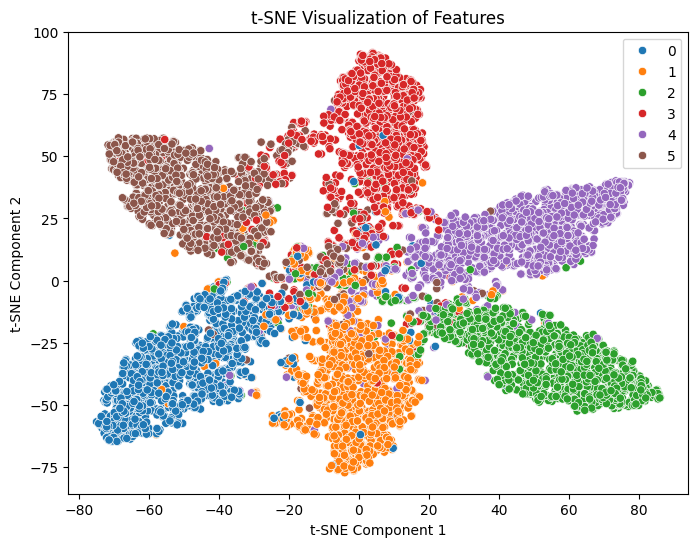

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from torchvision import models
from torchvision.transforms import ToPILImage
import seaborn as sns

def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    
    def hook_fn(module, input, output):
        features_batch.append(output.cpu())
    
    # Register hook to extract features before the final classifier
    hook = model.avgpool.register_forward_hook(hook_fn)
    
    with torch.no_grad():
        for images, lbls in dataloader:
            features_batch = []
            images = images.half().to(device)
            _ = model(images)  # Forward pass to trigger hook
            
            # Get features from hook and flatten
            feats = features_batch[0].squeeze()  # Remove spatial dimensions
            if feats.dim() > 2:
                feats = feats.view(feats.size(0), -1)  # Flatten if needed
            
            features.append(feats.cpu().detach().numpy())
            labels.append(lbls.cpu().detach().numpy())
    
    hook.remove()  # Clean up hook
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# Load best model for visualization
model = models.resnet18(weights=None, num_classes=6).to(device)
model.load_state_dict(torch.load("best_model_fold3_fp32.pth"))
model = model.half().to(device)

# Use a subset for visualization
subset_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
features, labels = extract_features(model, subset_loader, device)

# --- t-SNE Visualization ---
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)
plt.figure(figsize=(8,6))
sns.scatterplot(x=features_tsne[:,0], y=features_tsne[:,1], hue=labels, palette="tab10", legend="full")
plt.title("t-SNE Visualization of Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

#### 5.1.5. Visualize Grad-CAM for visual interpretability

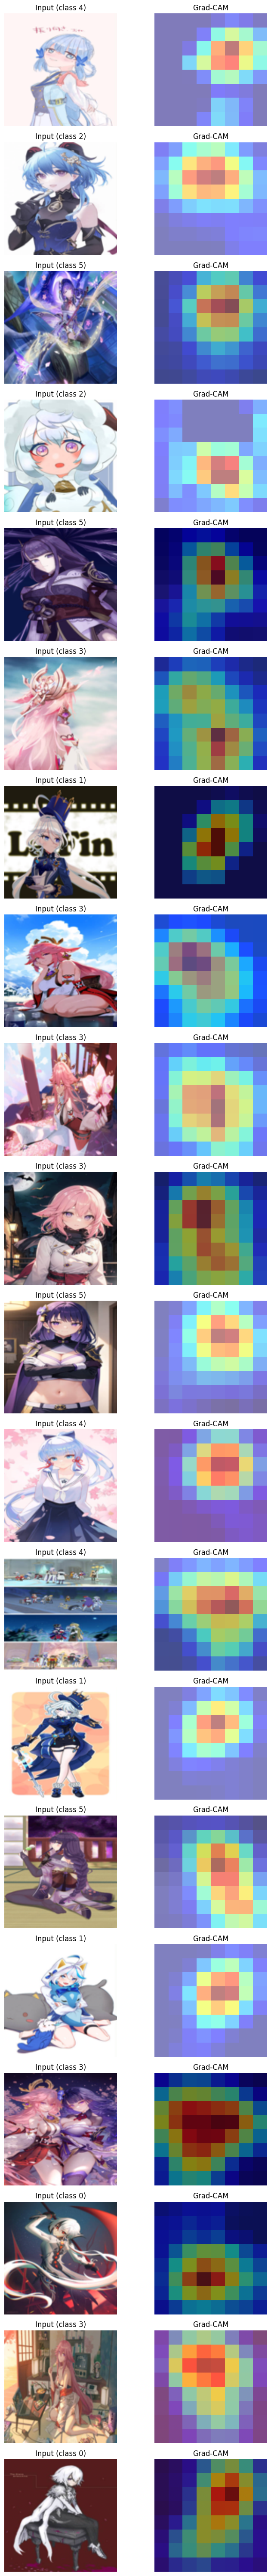

In [22]:
NUM_SAMPLES = 20

from torchvision.transforms import ToPILImage

def to_pil_image(tensor):
    """
    Converts a torch tensor image to a PIL Image.
    Handles normalization and channel order.
    """
    # If normalized, unnormalize using ImageNet stats
    imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    if tensor.ndim == 3 and tensor.shape[0] == 3:
        tensor = tensor.cpu().float()
        tensor = tensor * imagenet_std + imagenet_mean
        tensor = torch.clamp(tensor, 0, 1)
    return ToPILImage()(tensor)

def grad_cam(model, image, target_class, device):
    model.eval()
    image = image.unsqueeze(0).half().to(device)
    image.requires_grad_()
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].cpu().detach())

    def forward_hook(module, inp, out):
        activations.append(out.cpu().detach())

    # Register hooks to the last conv layer
    layer = model.layer4[-1].conv2
    handle_f = layer.register_forward_hook(forward_hook)
    handle_b = layer.register_backward_hook(backward_hook)

    output = model(image)
    score = output[0, target_class]
    model.zero_grad()
    score.backward()

    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    activation = activations[0][0]
    for i in range(activation.shape[0]):
        activation[i, ...] *= pooled_gradients[i]
    heatmap = activation.mean(dim=0).detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    handle_f.remove()
    handle_b.remove()
    return heatmap

# Visualize Grad-CAM for 20 random samples
indices = np.random.choice(len(dataset), NUM_SAMPLES, replace=False)
fig, axes = plt.subplots(NUM_SAMPLES, 2, figsize=(8, NUM_SAMPLES * 3))

for idx, sample_idx in enumerate(indices):
    sample_img, sample_label = dataset[sample_idx]
    heatmap = grad_cam(model, sample_img, sample_label, device)
    img = to_pil_image(sample_img)
    
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"Input (class {sample_label})")
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(img)
    axes[idx, 1].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[idx, 1].set_title("Grad-CAM")
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

#### 5.1.6. Visualize kernels and convolutional layers activation maps

Visualizing convolutional layers of the model...

1. Conv1 Filters:


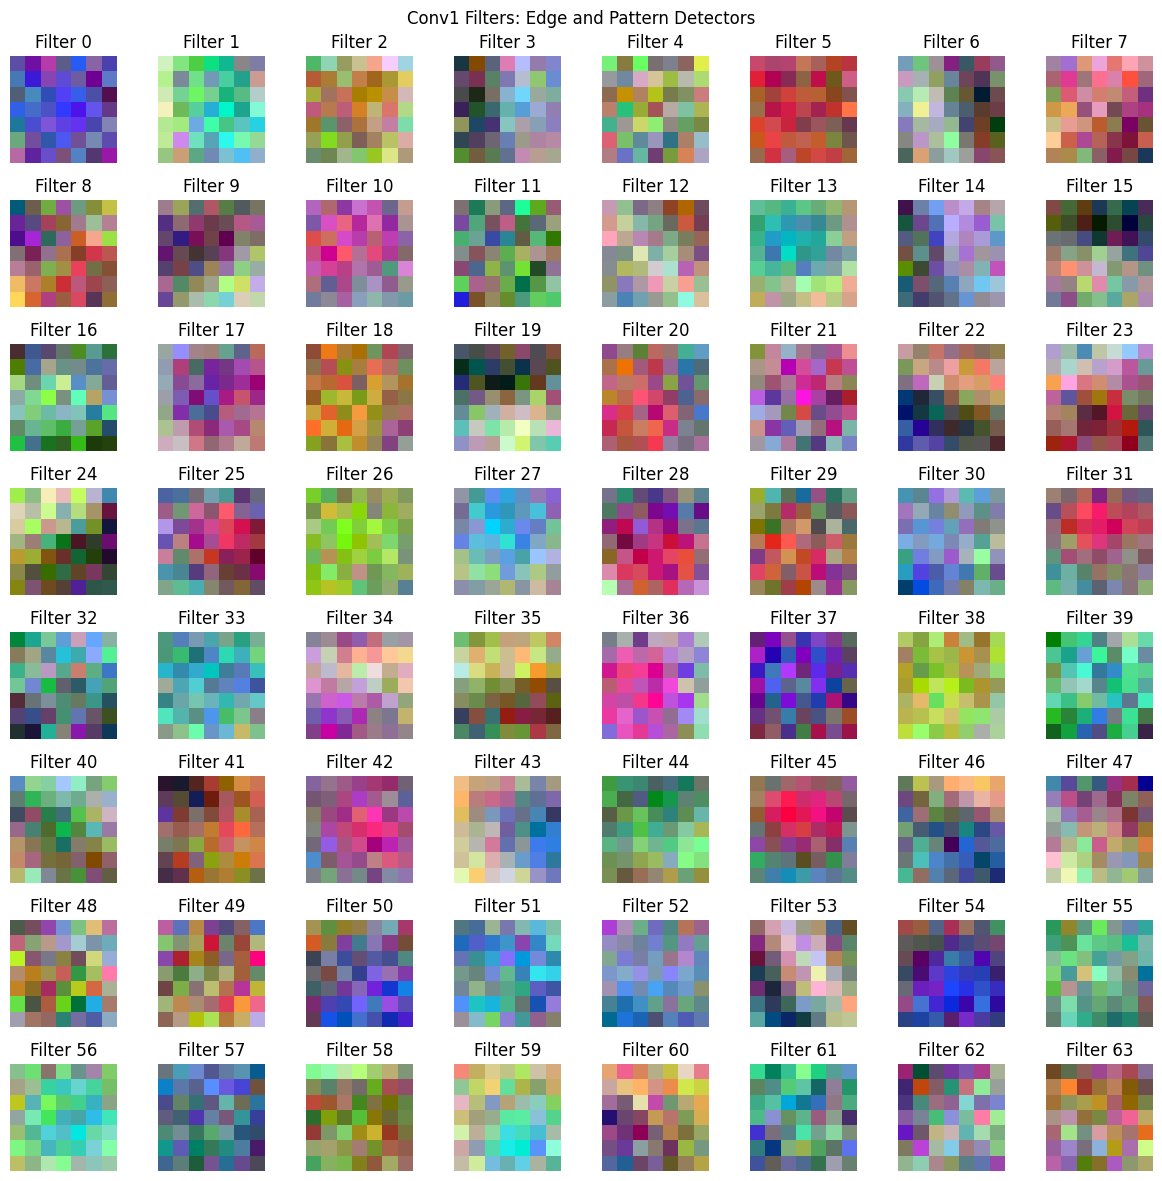


2. Conv1 Feature Maps:


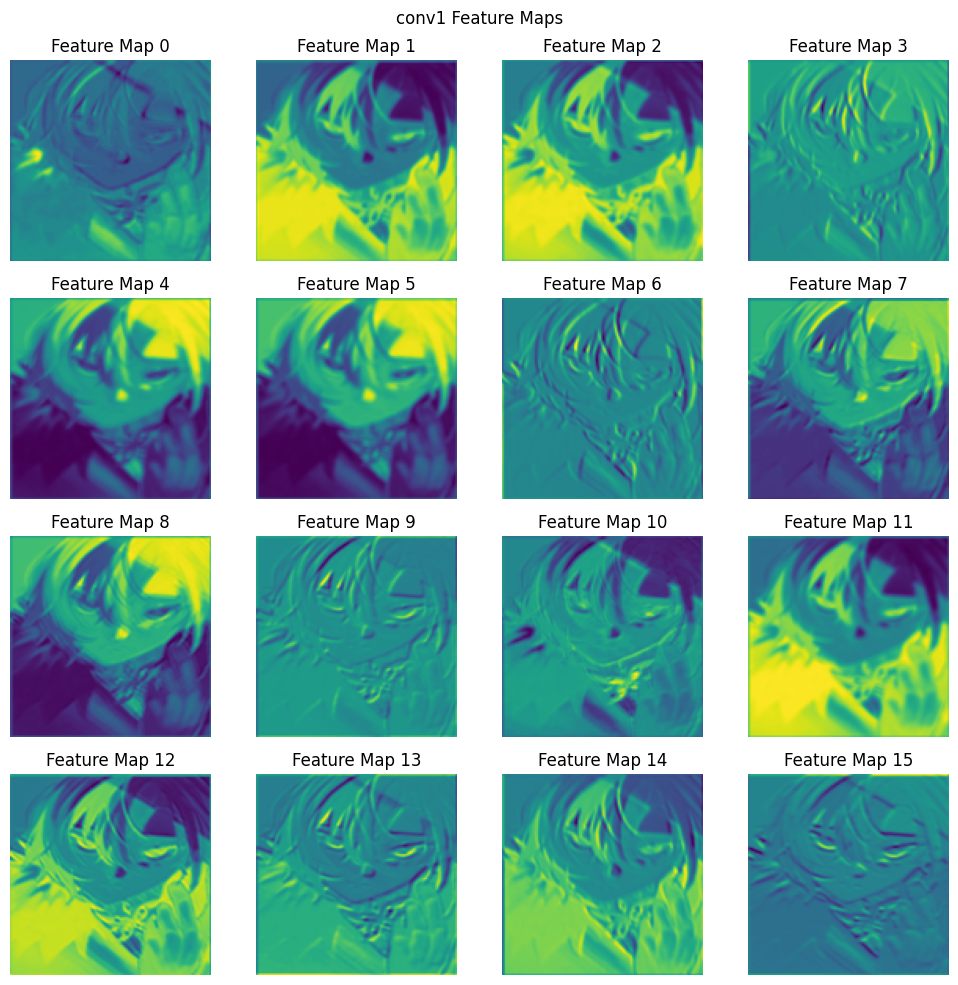


3. Layer1[0].conv2 Feature Maps:


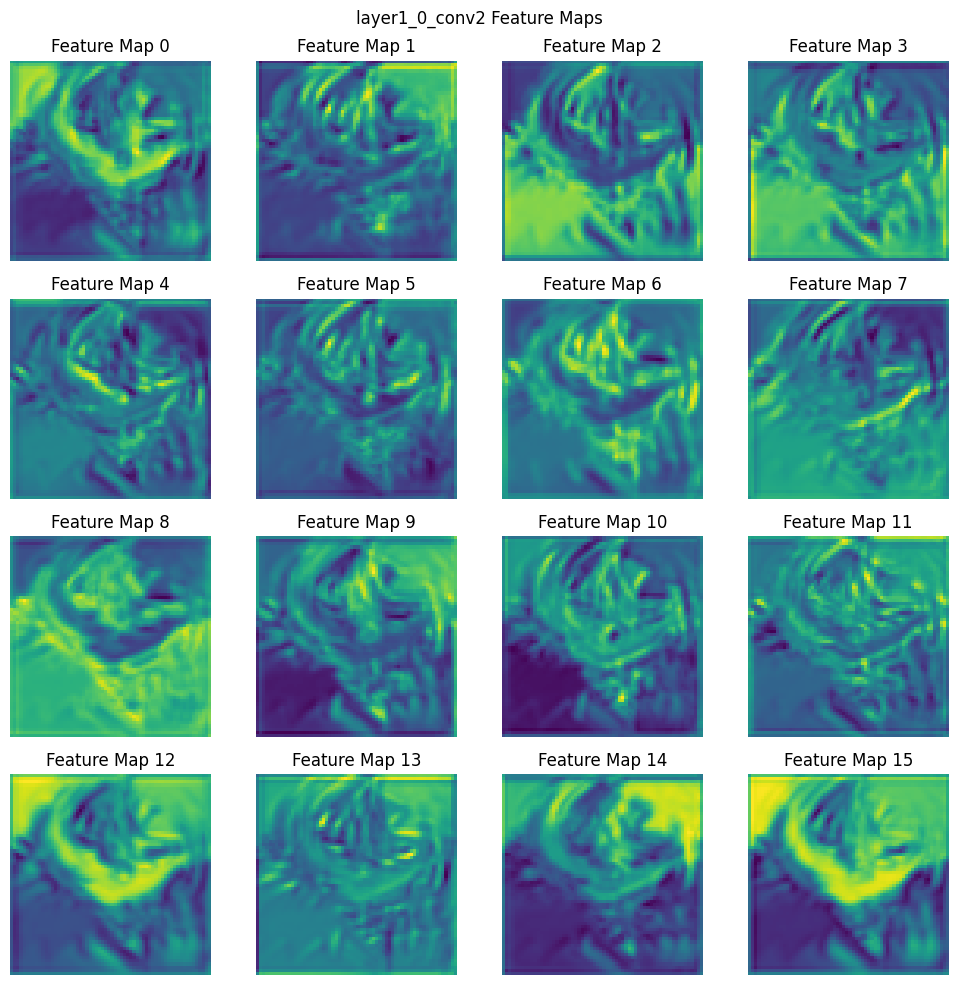


4. Layer2[0].conv2 Feature Maps:


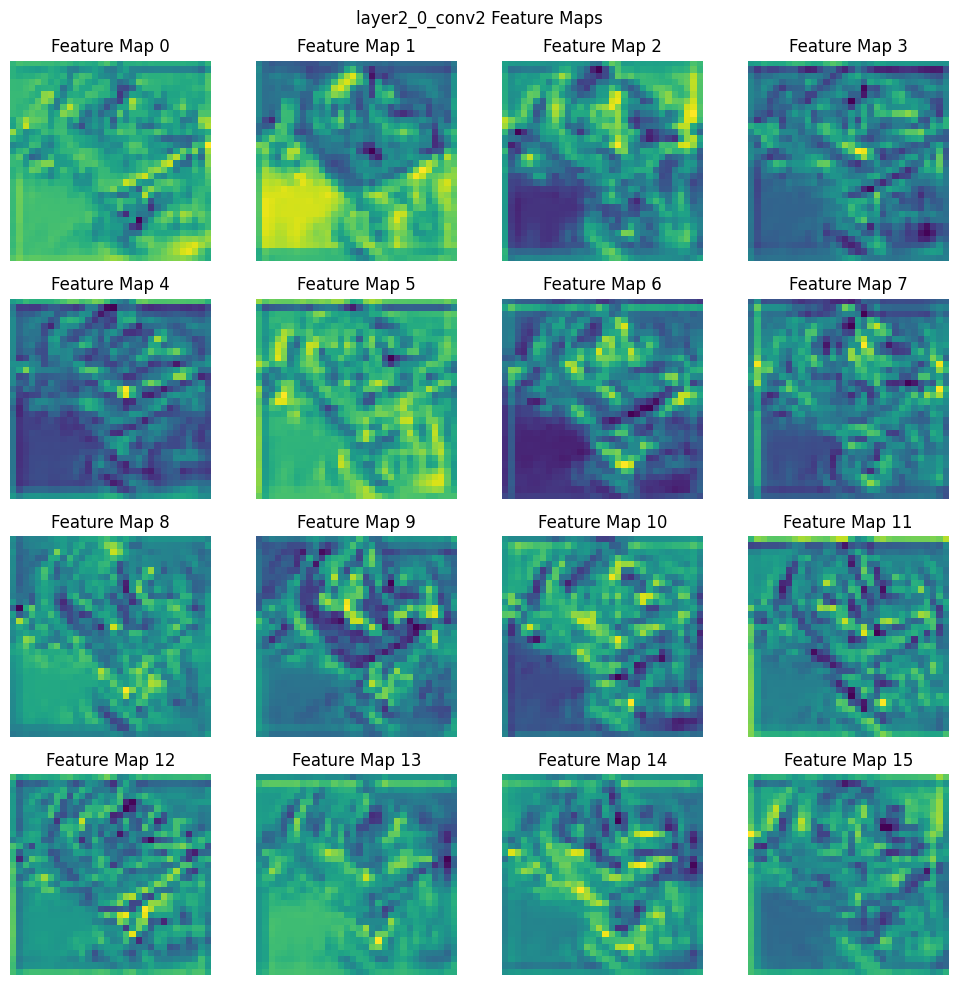


5. Layer3[0].conv2 Feature Maps:


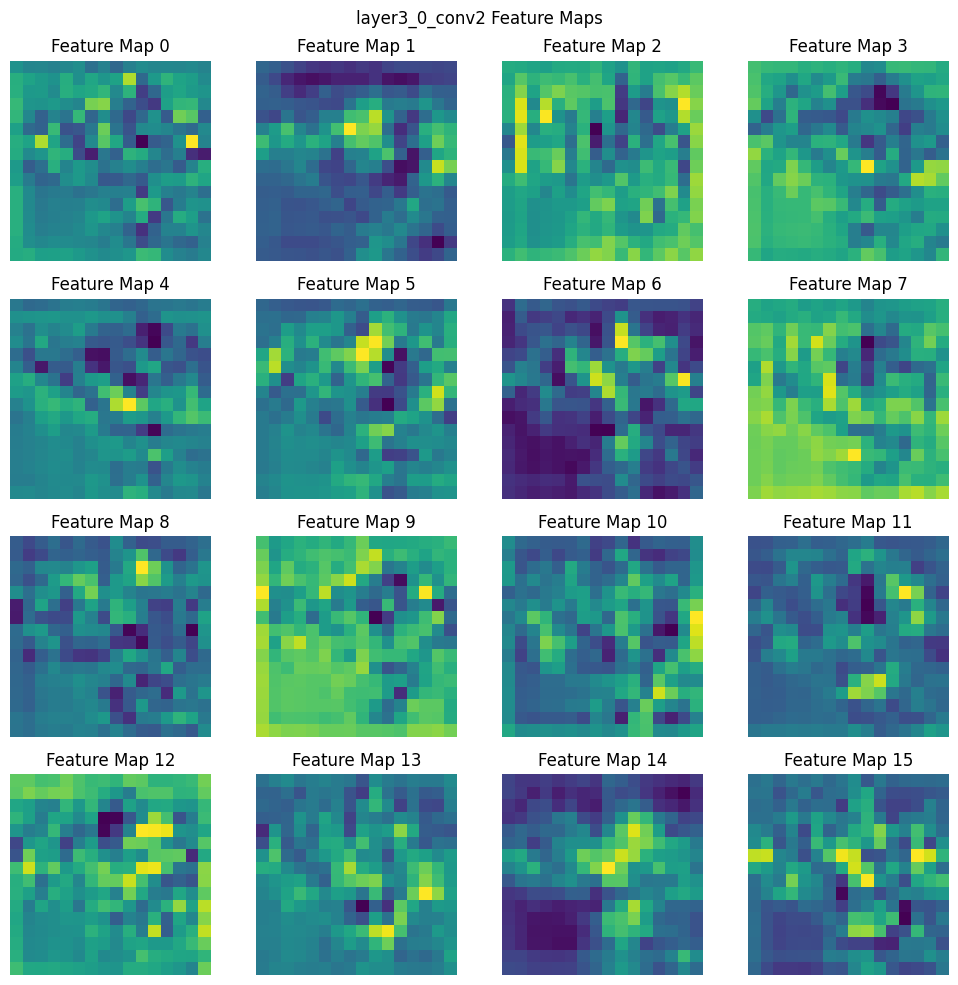


6. Layer4[0].conv2 Feature Maps:


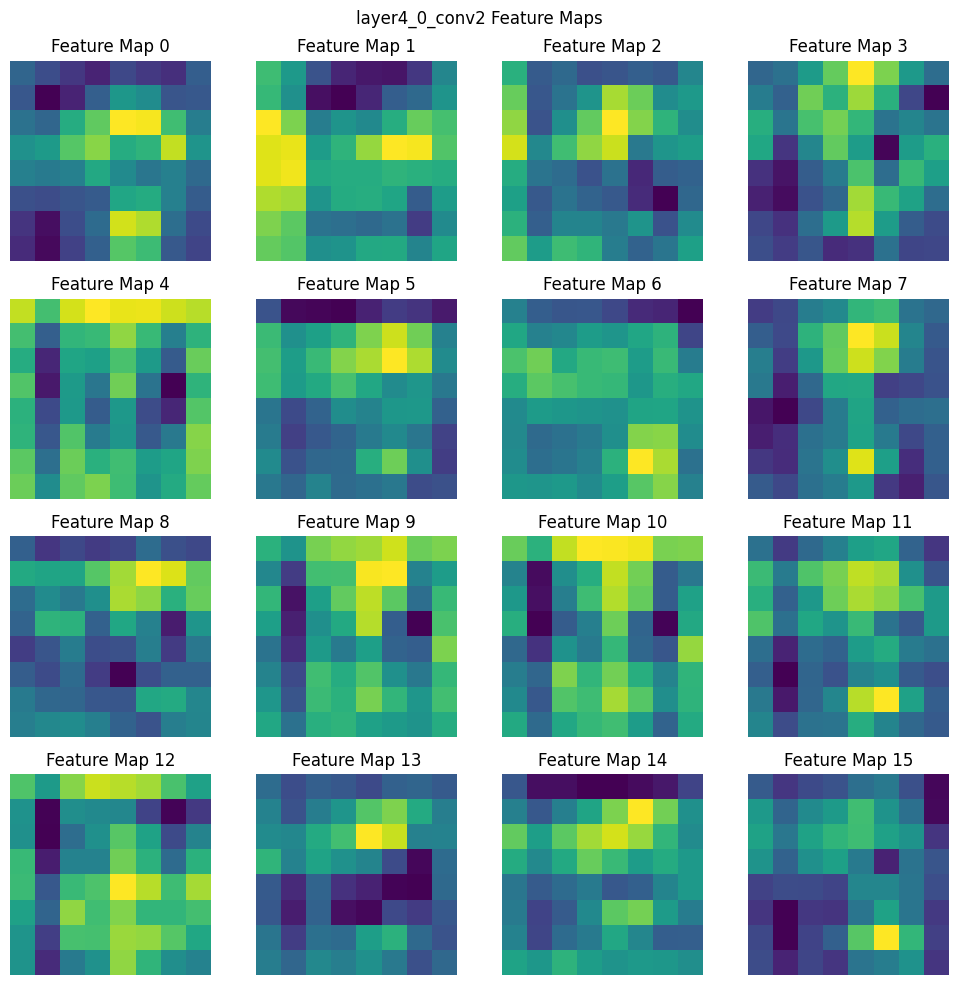


7. Layer4[-1].conv2 Feature Maps (last block):


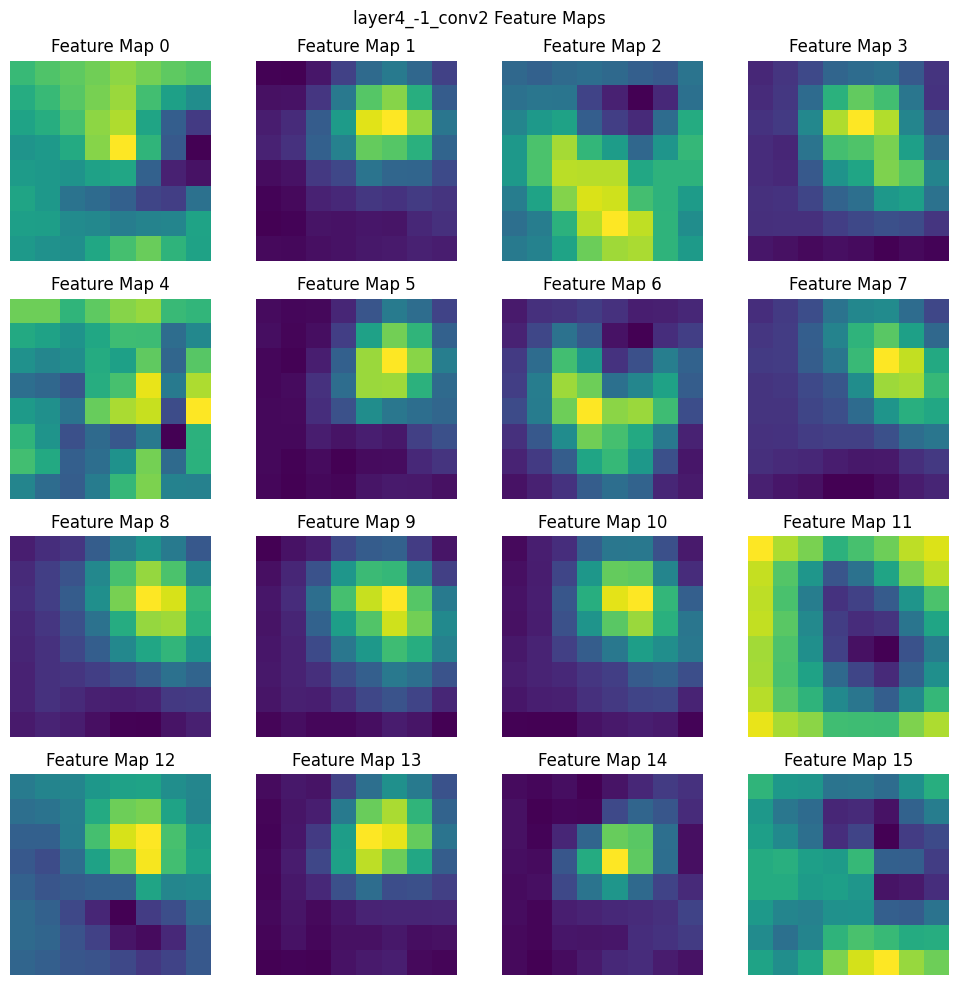


8. Rotation Sensitivity Analysis:


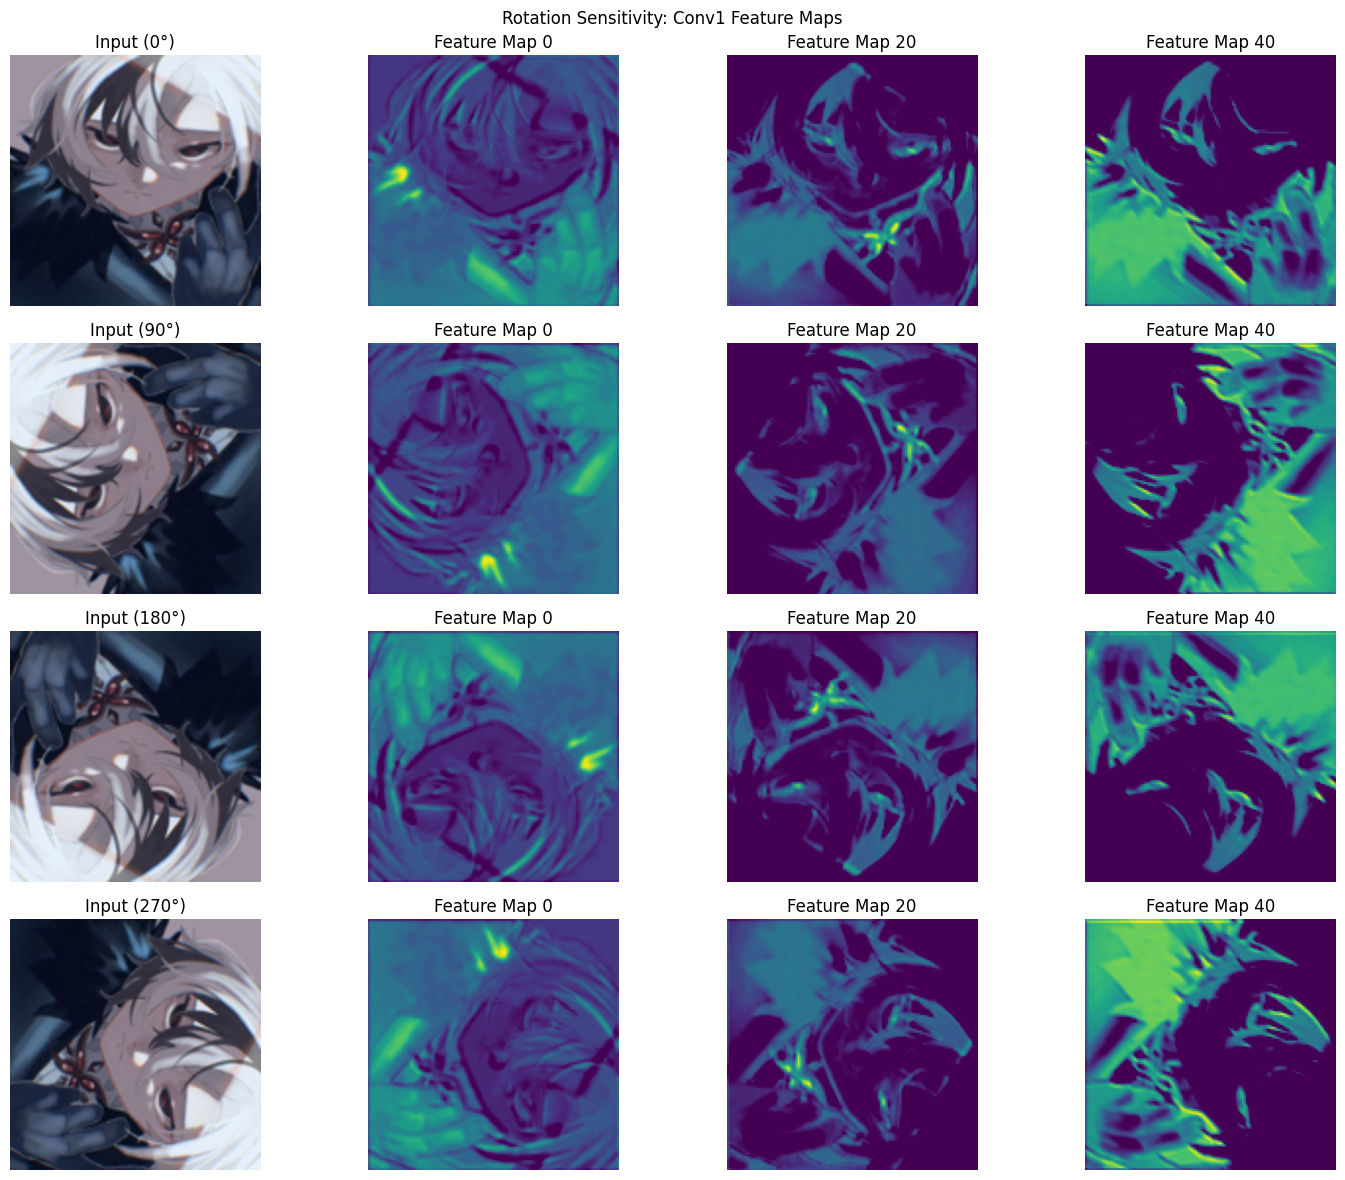

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

def visualize_conv1_filters(model):
    """Visualize the 64 filters in the first convolutional layer of ResNet-18"""
    conv1_weights = model.conv1.weight.data  # [64, 3, 7, 7]
    num_filters = conv1_weights.shape[0]
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i in range(num_filters):
        row, col = i // 8, i % 8
        filter_img = conv1_weights[i].cpu().float()
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min() + 1e-5)
        axes[row, col].imshow(filter_img.permute(1, 2, 0).numpy())
        axes[row, col].set_title(f'Filter {i}')
        axes[row, col].axis('off')
    plt.suptitle('Conv1 Filters: Edge and Pattern Detectors')
    plt.tight_layout()
    plt.show()

def visualize_feature_maps(model, input_image, layer_name):
    """Visualize feature maps produced by convolutional layers"""
    model.eval()
    input_image = input_image.unsqueeze(0).to(next(model.parameters()).device)
    activations = {}
    def hook_fn(module, input, output):
        activations[layer_name] = output.detach()
    # Register hook for selected layer
    layer_map = {
        'conv1': model.conv1,
        'layer1_0_conv2': model.layer1[0].conv2,
        'layer2_0_conv2': model.layer2[0].conv2,
        'layer3_0_conv2': model.layer3[0].conv2,
        'layer4_0_conv2': model.layer4[0].conv2,
        'layer4_-1_conv2': model.layer4[-1].conv2
    }
    if layer_name not in layer_map:
        raise ValueError(f"layer_name must be one of {list(layer_map.keys())}")
    hook = layer_map[layer_name].register_forward_hook(hook_fn)
    with torch.no_grad():
        _ = model(input_image)
    feature_maps = activations[layer_name][0]  # Remove batch dimension
    num_maps = min(16, feature_maps.shape[0])
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(num_maps):
        row, col = i // 4, i % 4
        fmap = feature_maps[i].cpu().float().numpy()
        fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)
        axes[row, col].imshow(fmap, cmap='viridis')
        axes[row, col].set_title(f'Feature Map {i}')
        axes[row, col].axis('off')
    hook.remove()
    plt.suptitle(f'{layer_name} Feature Maps')
    plt.tight_layout()
    plt.show()

def visualize_rotation_sensitivity(model, image):
    """Show how different rotations affect feature maps"""
    rotations = [0, 90, 180, 270]
    fig, axes = plt.subplots(len(rotations), 4, figsize=(15, 12))
    for i, angle in enumerate(rotations):
        rotated_img = transforms.functional.rotate(image, angle).unsqueeze(0).to(next(model.parameters()).device)
        model.eval()
        with torch.no_grad():
            conv1_out = torch.relu(model.conv1(rotated_img))
        input_vis = rotated_img.squeeze().permute(1,2,0).cpu().float().numpy()
        input_vis = (input_vis - input_vis.min()) / (input_vis.max() - input_vis.min() + 1e-5)
        axes[i, 0].imshow(input_vis)
        axes[i, 0].set_title(f'Input ({angle}°)')
        axes[i, 0].axis('off')
        for j in range(3):
            feature_idx = j * 20  # Show filters 0, 20, 40
            fmap = conv1_out[0, feature_idx].cpu().float().numpy()
            fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)
            axes[i, j+1].imshow(fmap, cmap='viridis')
            axes[i, j+1].set_title(f'Feature Map {feature_idx}')
            axes[i, j+1].axis('off')
    plt.suptitle('Rotation Sensitivity: Conv1 Feature Maps')
    plt.tight_layout()
    plt.show()

# Example usage:
print("Visualizing convolutional layers of the model...")

test_image, _ = dataset[0]
test_image = test_image.to(device).half()

print("\n1. Conv1 Filters:")
visualize_conv1_filters(model)

print("\n2. Conv1 Feature Maps:")
visualize_feature_maps(model, test_image, 'conv1')

print("\n3. Layer1[0].conv2 Feature Maps:")
visualize_feature_maps(model, test_image, 'layer1_0_conv2')

print("\n4. Layer2[0].conv2 Feature Maps:")
visualize_feature_maps(model, test_image, 'layer2_0_conv2')

print("\n5. Layer3[0].conv2 Feature Maps:")
visualize_feature_maps(model, test_image, 'layer3_0_conv2')

print("\n6. Layer4[0].conv2 Feature Maps:")
visualize_feature_maps(model, test_image, 'layer4_0_conv2')

print("\n7. Layer4[-1].conv2 Feature Maps (last block):")
visualize_feature_maps(model, test_image, 'layer4_-1_conv2')

print("\n8. Rotation Sensitivity Analysis:")
visualize_rotation_sensitivity(model, test_image)

### 5.2. Self-Supervised pre-training

#### 5.2.1. SimCLR data augmentation functions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('simclr_training.log'),
        logging.StreamHandler()
    ]
)

# Enable TF32 for faster training
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
logging.info(f"TF32 for cuDNN: {torch.backends.cudnn.allow_tf32}")
logging.info(f"TF32 for matmul: {torch.backends.cuda.matmul.allow_tf32}")

# Enable CuDNN benchmark for performance optimization on covolutional layers
torch.backends.cudnn.benchmark = True

logging.info(f"CuDNN benchmark enabled: {torch.backends.cudnn.benchmark}")

# --- SimCLR Data Augmentation ---
class SimCLRTransform:
    def __init__(self, size=224):
        # Transform for tensor inputs
        self.tensor_transform = T.Compose([
            T.RandomResizedCrop(size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
        ])
        
        # Transform for PIL inputs
        self.pil_transform = T.Compose([
            T.RandomResizedCrop(size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __call__(self, x):
        # Check if x is already a tensor
        if isinstance(x, torch.Tensor):
            xi = self.tensor_transform(x)
            xj = self.tensor_transform(x)
        else:
            xi = self.pil_transform(x)
            xj = self.pil_transform(x)
        return xi, xj

# --- SimCLR Projection Head ---
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden_dim=512, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

# --- SimCLR Model ---
class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        self.encoder = base_encoder
        self.projection_head = ProjectionHead(self.encoder.fc.in_features, 512, projection_dim)
        # Remove original FC layer
        self.encoder.fc = nn.Identity()
    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return h, z

# --- NT-Xent Loss ---
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    z = nn.functional.normalize(z, dim=1)
    similarity_matrix = torch.matmul(z, z.T)
    
    # Mask out self-similarity
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
    
    # Extract positive pairs
    positives = torch.cat([
        torch.diag(similarity_matrix, batch_size),
        torch.diag(similarity_matrix, -batch_size)
    ])
    
    # All pairs except self-similarity
    negatives = similarity_matrix[~mask].view(2 * batch_size, -1)
    
    # Concatenate positive pairs as first entry, then all negatives
    logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
    
    # Labels are zeros (indicating first entry - positive pair - is the correct one)
    labels = torch.zeros(2 * batch_size, dtype=torch.long, device=z.device)
    
    # Apply temperature scaling
    logits = logits / temperature
    
    # Cross-entropy loss
    loss = nn.CrossEntropyLoss()(logits, labels)
    return loss

# --- Training Loop ---
def train_simclr(
    dataset,
    epochs=500,
    batch_size=256,
    lr=0.5,
    temperature=0.5,
    projection_dim=128,
    weight_decay=1e-4,
    device='cuda',
    save_path="simclr_resnet18_encoder.pth",
    checkpoint_dir="checkpoints"  # <-- Added attribute for checkpoint folder
):
    logging.info("Setting up SimCLR pretraining with TF32 precision...")
    transform = SimCLRTransform(size=224)

    # Create dataset with SimCLR augmentation
    class SimCLRDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, transform):
            self.dataset = dataset
            self.transform = transform

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            img, _ = self.dataset[idx]  # Discard labels for self-supervised learning
            return self.transform(img)

    ssl_dataset = SimCLRDataset(dataset, transform)
    loader = DataLoader(
        ssl_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True,
        pin_memory=True
    )

    # Initialize model
    logging.info(f"Initializing ResNet-18 model for SimCLR pretraining...")
    base_encoder = models.resnet18(weights=None)
    model = SimCLR(base_encoder, projection_dim).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Check for latest checkpoint in checkpoint_dir
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_files = [
        f for f in os.listdir(checkpoint_dir)
        if f.startswith("simclr_resnet18_epoch") and f.endswith(".pth")
    ]
    if checkpoint_files:
        epochs_done = max([int(f.split("_epoch")[1].split(".")[0]) for f in checkpoint_files])
        checkpoint_path = os.path.join(checkpoint_dir, f"simclr_resnet18_epoch{epochs_done}.pth")
        logging.info(f"Resuming from checkpoint: {checkpoint_path} (epoch {epochs_done})")
        model.encoder.load_state_dict(torch.load(checkpoint_path))
        start_epoch = epochs_done
        # Load previous losses if available
        losses_path = os.path.join(checkpoint_dir, f"simclr_losses_epoch{epochs_done}.npy")
        if os.path.exists(losses_path):
            train_losses = list(np.load(losses_path))
            best_loss = min(train_losses)
        else:
            train_losses = []
            best_loss = float('inf')
        best_model_state = {k: v.detach().float().cpu() for k, v in model.encoder.state_dict().items()}
    else:
        logging.info("No checkpoint found, starting from scratch.")
        start_epoch = 0
        best_loss = float('inf')
        best_model_state = None
        train_losses = []

    start_time_total = time.time()
    logging.info(f"Starting SimCLR pretraining for {epochs} epochs on {len(dataset)} images...")

    for epoch in range(start_epoch, epochs):
        model.train()
        epoch_loss = 0.0
        start_time = time.time()

        progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for xi, xj in progress_bar:
            xi, xj = xi.to(device), xj.to(device)
            optimizer.zero_grad()
            _, zi = model(xi)
            _, zj = model(xj)
            loss = nt_xent_loss(zi, zj, temperature)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        scheduler.step()
        avg_epoch_loss = epoch_loss / len(loader)
        train_losses.append(avg_epoch_loss)
        epoch_time = time.time() - start_time
        logging.info(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_epoch_loss:.4f} - Time: {epoch_time:.2f}s")

        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            best_model_state = {k: v.detach().float().cpu() for k, v in model.encoder.state_dict().items()}
            logging.info(f"  Saved new best model with loss: {best_loss:.4f}")

        if (epoch + 1) % 50 == 0 or (epoch + 1) == epochs:
            checkpoint_path = os.path.join(checkpoint_dir, f"simclr_resnet18_epoch{epoch+1}.pth")
            intermediate_model_state = {k: v.detach().float().cpu() for k, v in model.encoder.state_dict().items()}
            torch.save(intermediate_model_state, checkpoint_path)
            logging.info(f"  Saved checkpoint at epoch {epoch+1} to {checkpoint_path}")
            # Save current loss curve
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses)
            plt.title('SimCLR Training Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.grid(True)
            plt.savefig(os.path.join(checkpoint_dir, f'simclr_loss_epoch{epoch+1}.png'))
            plt.close()
            np.save(os.path.join(checkpoint_dir, f"simclr_losses_epoch{epoch+1}.npy"), np.array(train_losses))

    total_time = time.time() - start_time_total
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    logging.info(f"Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

    final_model_state = {k: v.detach().float().cpu() for k, v in model.encoder.state_dict().items()}
    torch.save(final_model_state, f"{save_path}_final.pth")
    torch.save(best_model_state, save_path)
    logging.info(f"SimCLR pretraining complete.")
    logging.info(f"Best model (loss: {best_loss:.4f}) saved to {save_path}")
    logging.info(f"Final model saved to {save_path}_final.pth")
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.title('SimCLR Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('simclr_training_loss_final.png')
    plt.show()
    return model.encoder, train_losses

2025-07-20 14:41:36,843 - INFO - TF32 for cuDNN: True
2025-07-20 14:41:36,845 - INFO - TF32 for matmul: True
2025-07-20 14:41:36,846 - INFO - CuDNN benchmark enabled: True


In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    checkpoint_dir = '/content/drive/MyDrive/simclr_checkpoints'
except ImportError:
    checkpoint_dir = 'checkpoints'

In [ ]:
# Train SimCLR with ResNet-18 for 500 epochs
train_simclr(
    dataset=combined_dataset,
    epochs=500,
    batch_size=128,
    lr=0.01,
    temperature=0.5,
    projection_dim=128,
    weight_decay=1e-4,  # Increased from 1e-6 to 1e-4 for better regularization
    device=device,
    save_path="simclr_resnet18_encoder_140k.pth",
    checkpoint_dir=checkpoint_dir  # Use the checkpoint directory
)